In [2]:
from scipy.io import wavfile
fs1, tone1 = wavfile.read('Tone 1.wav')
fs2, tone2 = wavfile.read('Tone 2.wav')
fs3, tone3 = wavfile.read('Tone 3.wav')



<ipython-input-2-78507a8800fa>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs3, tone3 = wavfile.read('Tone 3.wav')


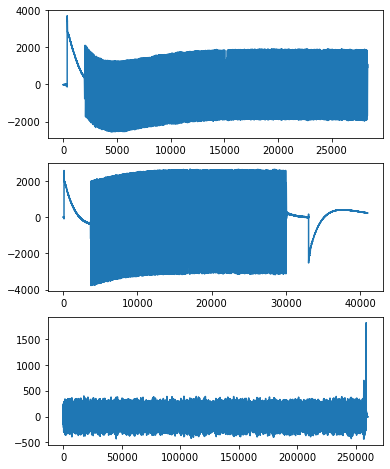

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(6, 8))

axs[0].plot(tone1)
axs[1].plot(tone2)
axs[2].plot(tone3)

(0.0, 0.1)

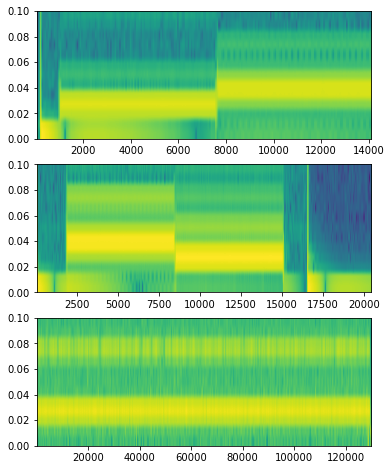

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(6, 8))

output1 = axs[0].specgram(tone1)
axs[0].set_ylim([0,0.1])
output2 = axs[1].specgram(tone2)
axs[1].set_ylim([0,0.1])
output3 = axs[2].specgram(tone3)
axs[2].set_ylim([0,0.1])


In [63]:
#
# QNF - The Quinn - Fernandes frequency estimator.
#
#          Inputs:  signal - T x N matrix where
#                            T = data length
#                            N = number of signals
#                            (i.e. N signals in columns).
#
#          Outputs: est - N Quinn-Fernandes frequency estimates.
#
# [1]  B.G. Quinn & J.M. Fernandes, "A fast technique for the estimation of frequency,"
#      Biometrika, Vol. 78(3), pp. 489--497, 1991.

# $Id: qnf.m 1.1 2000/06/07 18:57:16 PeterK Exp PeterK $

# File: qnf.m
#
# Copyright (C) 1993 CRC for Robust & Adaptive Systems
# 
# This software provided under the GNU General Public Licence, which
# is available from the website from which this file originated. For
# a copy, write to the Free Software Foundation, Inc., 675 Mass Ave, 
# Cambridge, MA 02139, USA.

import numpy as np
import scipy.signal as signal

def qnf(sig):
    if type(sig) is not np.ndarray:
        raise Exception("signal must be an np.ndarray")
        
    #
    # Initializations
    #
    shape=sig.shape;
    t = shape[0]
    if t < 4:
        raise Exception("signal must be longer than 1 point")
        
    if (len(shape)==1):
        ns = 1
        sig = np.array([sig]).T
    else:
        ns = shape[1]
        
    xb = np.mean(sig, axis=0)
    
    if (len(xb.shape) == 1):
        xbm = np.multiply(np.ones([t,1]),xb)
    else:
        xbm = np.matmul(np.ones([t,1]),xb)

    sig=np.subtract(sig,xbm)
    t3 = t+1
    
    y = np.fft.fft(sig, n=2*t, axis=0)
    
    z=np.multiply(y,np.conj(y))
    z=z[2:t3,]

    [m,j]= z[2:t-1,].max(axis=0), z[2:t-1,].argmax(axis=0) 

    j=j+1 # TODO: Not needed because of zero indexing?

    a=2*np.cos(np.pi*j/t)
    y=y[1:2*t:2]
    
    #
    # Quinn-Fernandes method
    #
    b=[1];
    nm=t-1;
    for jjj in [1,2,3,4]:
        for q in np.arange(ns):
            c=[1,-a[q],1];
            y[:,q] = signal.lfilter(b,c,sig[:,q])

        v = np.sum(np.divide(np.multiply(sig[2:t,],y[1:nm,]),np.sum(np.multiply(y[1:nm,],y[1:nm,]))))
        a = np.add(a,2*v);

    return np.real(np.arccos(a/2));

    # Author: SJS 1992; Adapted from code within ttinpie.m (author PJK)
    #
    # Based on: P.J. Kootsookos, S.J. Searle and B.G. Quinn, 
    # "Frequency Estimation Algorithms," CRC for Robust and 
    # Adaptive Systems Internal Report, June 1993.


In [6]:
qnf(tone1[2000:4000])

array([0.07395322])

In [7]:
def short_term_qnf(sig, Nsegs = 50):
    T = len(sig)
    SegLen = T//Nsegs
    freqs = []
    for t in np.linspace(0,T,Nsegs).astype(int):
        if len(sig[t:(t+SegLen)]) > 4:
            freqs.append(qnf(sig[t:(t+SegLen)])[0])
    
    return freqs


(0.0, 0.1)

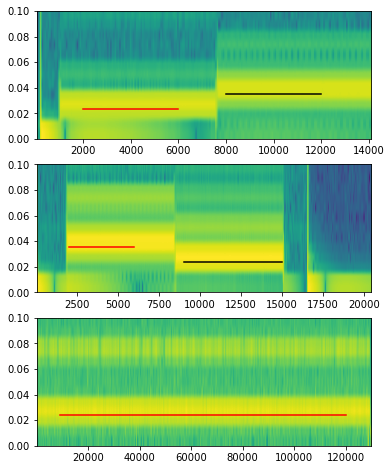

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(6, 8))

output1 = axs[0].specgram(tone1)
axs[0].set_ylim([0,0.1])
axs[0].plot([2000,6000], qnf(tone1[4000:12000])*[1/np.pi,1/np.pi],'r')
axs[0].plot([8000,12000], qnf(tone1[16000:24000])*[1/np.pi,1/np.pi],'k')
output2 = axs[1].specgram(tone2)
axs[1].plot([2000,6000], qnf(tone2[4000:12000])*[1/np.pi,1/np.pi],'r')
axs[1].plot([9000,15000], qnf(tone2[18000:30000])*[1/np.pi,1/np.pi],'k')
axs[1].set_ylim([0,0.1])
output3 = axs[2].specgram(tone3)
axs[2].plot([9000,120000], qnf(tone3[18000:240000])*[1/np.pi,1/np.pi],'r')
axs[2].set_ylim([0,0.1])




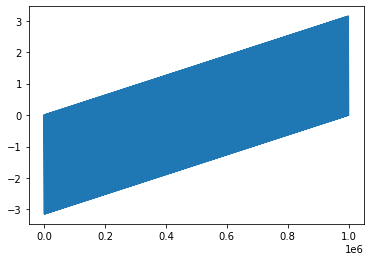

In [68]:
Nruns = 1000
results = np.zeros(shape=(Nruns*Nruns,3))
run_number = 0
for omega in np.linspace(0.001,np.pi,Nruns):
    for phi in np.linspace(0,np.pi,Nruns):
        results[run_number] =  [omega,phi,qnf(np.sin(omega*np.arange(0,1000)+phi))[0]]
        run_number = run_number + 1
    

    

In [69]:
print(results)

[[1.00000000e-03 0.00000000e+00 3.72756651e-03]
 [1.00000000e-03 3.14473739e-03 3.72781967e-03]
 [1.00000000e-03 6.28947478e-03 3.72807428e-03]
 ...
 [3.14159265e+00 3.13530318e+00 3.14159265e+00]
 [3.14159265e+00 3.13844792e+00 3.14159265e+00]
 [3.14159265e+00 3.14159265e+00 3.14159265e+00]]


(-0.0001, 0.0001)

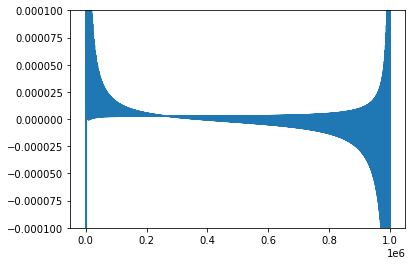

In [72]:
plt.plot(results[:,0]-results[:,2])
plt.ylim([-0.0001,0.0001])